In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import librosa
from keras.utils import to_categorical

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\BanglaAudio'


In [3]:
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [4]:
from sklearn.model_selection import train_test_split

def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def save_data_to_array(path=DATA_PATH, max_pad_len=30):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_pad_len=max_pad_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)
        
        
max_pad_len=30

def wav2mfcc(file_path, max_pad_len=30):
    wave, sr = librosa.load(file_path)
    mfcc = librosa.feature.melspectrogram(wave, sr=sr)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

In [5]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\BanglaAudio'


#db = r'C:\Users\lenovo_pc\Desktop\CNN_SR\SampleData'


# Second dimension of the feature is dim2
feature_dim_2 = 30

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 128
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [6]:

#X_train = np.array(x_train)
print(X_train.shape)
print(X_test.shape)


(38, 128, 30)
(26, 128, 30)


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [25]:
seq_length = 128

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(seq_length,30)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
#model.fit(x_train, y_train, batch_size=7, epochs=10)

history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 38 samples, validate on 26 samples
Epoch 1/50
38/38 [==============================] - 5s 138ms/step - loss: 0.6041 - acc: 0.6579 - val_loss: 0.7828 - val_acc: 0.7115
Epoch 2/50
38/38 [==============================] - 2s 53ms/step - loss: 0.8097 - acc: 0.7500 - val_loss: 0.9934 - val_acc: 0.5385
Epoch 3/50
38/38 [==============================] - 2s 53ms/step - loss: 0.8058 - acc: 0.5526 - val_loss: 0.1368 - val_acc: 1.0000
Epoch 4/50
38/38 [==============================] - 2s 50ms/step - loss: 0.2325 - acc: 0.9211 - val_loss: 0.0548 - val_acc: 1.0000
Epoch 5/50
38/38 [==============================] - 2s 50ms/step - loss: 0.0597 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 1.0000
Epoch 6/50
38/38 [==============================] - 2s 51ms/step - loss: 0.0657 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 1.0000
Epoch 7/50
38/38 [==============================] - 2s 56ms/step - loss: 0.0435 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 1.0000
Epoch 8/50
38/38 [====================

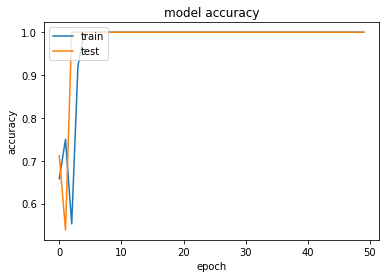

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


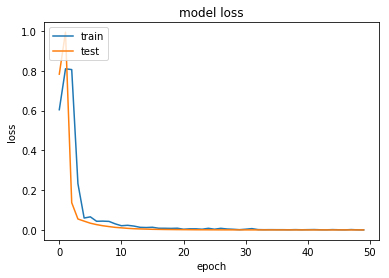

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
seq_length = 128

model = Sequential()
model.add(Conv1D(64, 4, activation='relu', input_shape=(seq_length,30)))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 2, activation='relu'))
model.add(Conv1D(256, 2, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [37]:

history = model.fit(X_train, y_train_hot, batch_size=7, epochs=10, validation_data=(X_test, y_test_hot))

Train on 38 samples, validate on 26 samples
Epoch 1/10
38/38 [==============================] - 8s 201ms/step - loss: 0.7035 - acc: 0.4079 - val_loss: 0.6781 - val_acc: 0.6731
Epoch 2/10
38/38 [==============================] - 5s 144ms/step - loss: 0.6782 - acc: 0.6184 - val_loss: 0.6614 - val_acc: 0.7885
Epoch 3/10
38/38 [==============================] - 6s 165ms/step - loss: 0.6586 - acc: 0.6711 - val_loss: 0.6415 - val_acc: 0.8846
Epoch 4/10
38/38 [==============================] - 7s 183ms/step - loss: 0.6355 - acc: 0.8026 - val_loss: 0.6171 - val_acc: 0.9231
Epoch 5/10
38/38 [==============================] - 6s 166ms/step - loss: 0.6199 - acc: 0.8026 - val_loss: 0.5868 - val_acc: 0.9231
Epoch 6/10
38/38 [==============================] - 7s 193ms/step - loss: 0.5802 - acc: 0.8421 - val_loss: 0.5477 - val_acc: 0.9423
Epoch 7/10
38/38 [==============================] - 6s 160ms/step - loss: 0.5673 - acc: 0.7500 - val_loss: 0.5019 - val_acc: 0.9615
Epoch 8/10
38/38 [==============

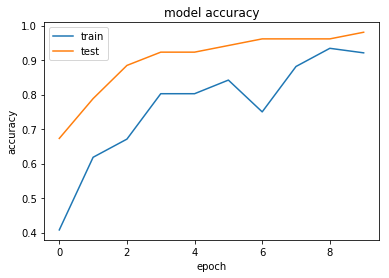

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

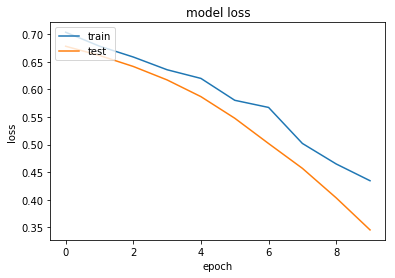

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [9]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (128,30)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           24320     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 36,802
Trainable params: 36,802
Non-trainable params: 0
_________________________________________________________________


In [11]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=50
MAX_BATCH=7

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_train, y_train_hot, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(X_test, y_test_hot),
                  callbacks=callback) 

print ("training finised!")




training started..... please wait.

Epoch 00001: loss improved from inf to 0.69024, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.69024 to 0.68256, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.68256 to 0.67774, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.67774 to 0.66547, saving model to ./best_model_trained.hdf5

Epoch 00005: loss improved from 0.66547 to 0.61188, saving model to ./best_model_trained.hdf5

Epoch 00006: loss improved from 0.61188 to 0.51389, saving model to ./best_model_trained.hdf5

Epoch 00007: loss improved from 0.51389 to 0.35278, saving model to ./best_model_trained.hdf5

Epoch 00008: loss did not improve from 0.35278

Epoch 00009: loss improved from 0.35278 to 0.31722, saving model to ./best_model_trained.hdf5

Epoch 00010: loss improved from 0.31722 to 0.29508, saving model to ./best_model_trained.hdf5

Epoch 00011: loss did not improve from 0.29508

Epoch 00012: loss

In [15]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")


model train data score       :  95.0 %
model test data score        :  100.0 %


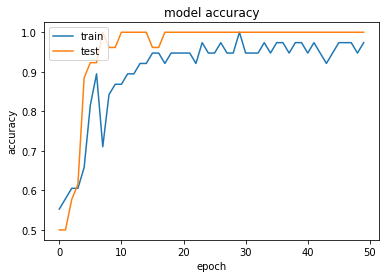

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

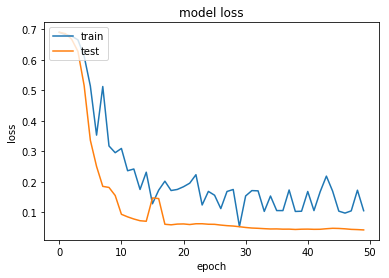

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()